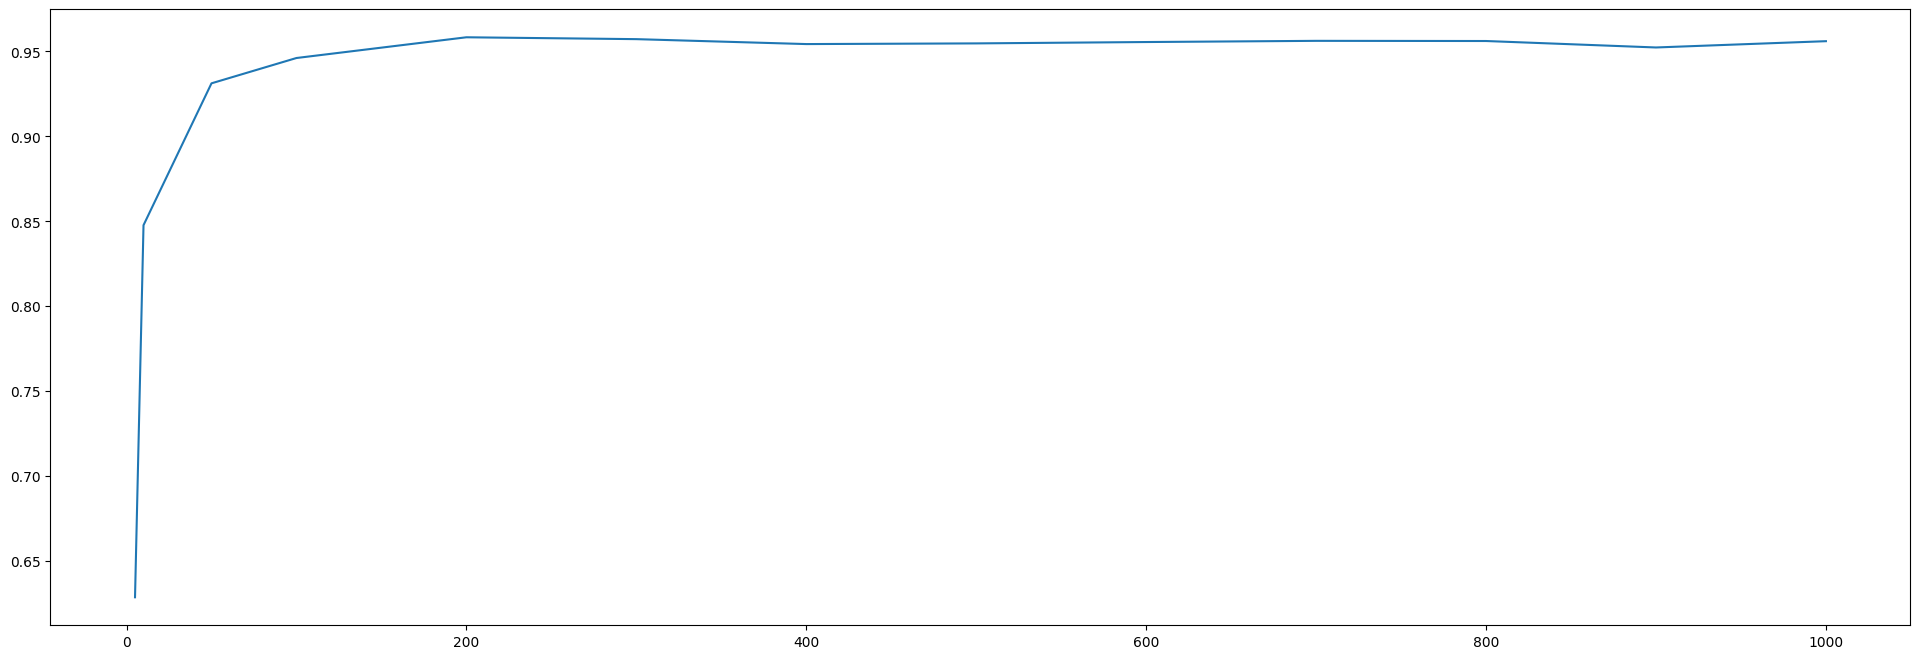

x = [5, 10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
y = [0.6287, 0.8477, 0.9312, 0.9461, 0.9583, 0.9572, 0.9543, 0.9547, 0.9555, 0.9562, 0.9561, 0.9523, 0.956]


In [1]:
# 计算模块
import numpy as np
# 特殊公式模块
import scipy.special as sp
import os
import matplotlib.pyplot as plt
#  交互式环境专用，清空输出
from IPython.display import clear_output

def draw():
    clear_output()
    plt.subplots(figsize=(24, 8))
    plt.plot(x, y)
    plt.show()

# 随机权重矩阵
def random_weight_matrix(len1, len2):
    # 正态分布
    return np.random.normal(0.0, pow(len1, -0.5), (len1, len2))

# 转为矩阵
def convert_matrix(list):
    return np.array(list, ndmin=2).T

# 计算操作
def output_calc(weight, input, activation_fn):
    return activation_fn(np.dot(weight, input))

# 标准化输入
def normalize_mtx(arr):
    return np.asfarray(arr[1:]) / 255 * 0.99 + 0.01

# 将相对路径转为绝对路径
def abs_dir(relative_path):
    # return os.path.abspath(relative_path)
    return os.path.normpath(os.path.join(os.path.dirname(os.path.abspath('__file__')), relative_path))


# 定义神经网络类
class neuralNetwork:
    # 初始化神经网络
    def __init__(self, nodes_info, learning_grate):
        # 输入层、隐藏层、输出层
        self.nodes_input = nodes_info['input']
        self.nodes_hide = nodes_info['hide']
        self.nodes_output = nodes_info['output']

        # 学习率
        self.lr = learning_grate

        # 输入层与隐藏层之间的权重矩阵
        self.w_ih = random_weight_matrix(self.nodes_hide, self.nodes_input)
        # 隐藏层与输出层之间的权重矩阵
        self.w_ho = random_weight_matrix(self.nodes_output, self.nodes_hide)

		# 激活函数（sigmoid）
        self.activation_fn = lambda x: sp.expit(x)

    # 训练神经网络
    def train(self, input_list, target_list):
        input = convert_matrix(input_list)
        target = convert_matrix(target_list)

        # input = convert_matrix(input_list)
        self.query(input_list)

        # 算出误差（目标 - 结果）
        # 输出层误差
        output_error = target - self.final_output
        # 隐藏层误差
        hidden_error = np.dot(self.w_ho.T, output_error)

        # 通过误差修改
        self.w_ho += self.lr * np.dot((output_error * self.final_output * (1 - self.final_output)), np.transpose(self.hidden_output))
        self.w_ih += self.lr * np.dot((hidden_error * self.hidden_output * (1 - self.hidden_output)), np.transpose(input))

    # 查询神经网络
    def query(self, input_list):
        self.hidden_output = output_calc(self.w_ih, convert_matrix(input_list), self.activation_fn)
        self.final_output = output_calc(self.w_ho, self.hidden_output, self.activation_fn)
        return self.final_output

def train_neural_network(info):
    init = {
        'node_info': (784, 100, 10),
        'learning_grate': 0.3,
        'train_file': 'train.csv',
        'epochs': 2,
        'callback': lambda c: "print('测试')",
        'callback_each_epoch': lambda i, c: "print(f'第{i}世代', c)"
    }

    for key in info.keys():
        init[key] = info[key]
    n_i, n_h, n_o = init['node_info']
    # 节点信息
    neural_node_info = {
        'input': n_i,
        'hide': n_h,
        'output': n_o
    }

    # 实例化一个神经网络对象
    example = neuralNetwork(neural_node_info, init['learning_grate'])
    # 以列表载入mnist训练数据集文件内容
    with open(abs_dir(init['train_file'])) as training_data_file:
        training_data_list = training_data_file.readlines()

    for e in range(init['epochs']):
        # 遍历训练数据集中的所有记录
        for record in training_data_list:
            # 用逗号分隔记录
            val_arr = record.split(',')
            # 转换输入
            inputs = normalize_mtx(val_arr)
            # 设定目标值
            targets = np.zeros(neural_node_info['output']) + 0.01
            # val_arr[0] 就是此记录的目标
            targets[int(val_arr[0])] = 0.99

            example.train(inputs, targets)
        init['callback_each_epoch'](e + 1, example)
    # 回调输入
    init['callback'](example)
    return example

def query_neural_network(neural_network_class, test_file):
    # 以数组存储测试数据
    with open(abs_dir(test_file)) as test_data_file:
        test_data_list = test_data_file.readlines()

    # 添加计分板
    scorecard = []

    for record in test_data_list:
        val_arr = record.split(',')

        correct_label = int(val_arr[0])
        # print(f'目标值:{correct_label}')

        inputs = normalize_mtx(val_arr)

        # 学习成果
        output = neural_network_class.query(inputs)

        # 得出最大值
        label = np.argmax(output)
        # print(f'实际值: {label}')

        # 如果成功算出则加1，反之加0
        if (label == correct_label):
            scorecard.append(1)
        else:
            scorecard.append(0)


    scorecard_arr = np.asarray(scorecard)
    score = scorecard_arr.sum() / scorecard_arr.size
    return (scorecard, score)

# 调用
step = (5, 10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000)
x = []
y = []
for i in step:
    train_info = {
        'node_info': (784, i, 10),
        'learning_grate': 0.3,
        'train_file': './mnist_dataset/pjreddie/mnist_train.csv',
        'epochs': 1,
        'callback': lambda c: append_score(i, c),
        # 'callback_each_epoch': lambda i,c: append_score(i, c)
    }
    def append_score(index, n_class):
        global x, y
        x.append(index)
        y.append(query_neural_network(n_class, './mnist_dataset/pjreddie/mnist_test.csv')[1])
        draw()
    train_neural_network(train_info)

    

print(f'x = {x}')
print(f'y = {y}')
# score =  query_neural_network(nn, './mnist_dataset/mini/mnist_test_10.csv')
# print(score)